
Training LSTM model...
Loaded existing model for LSTM from best_model_LSTM.pt
[LSTM] Epoch 100/100, Training Loss: 0.000159

Training GRU model...
Loaded existing model for GRU from best_model_GRU.pt
[GRU] Epoch 100/100, Training Loss: 0.000148

Training RNN model...
Loaded existing model for RNN from best_model_RNN.pt
[RNN] Epoch 100/100, Training Loss: 0.000270

Training CNN model...
Loaded existing model for CNN from best_model_CNN.pt
[CNN] Epoch 100/100, Training Loss: 0.000090


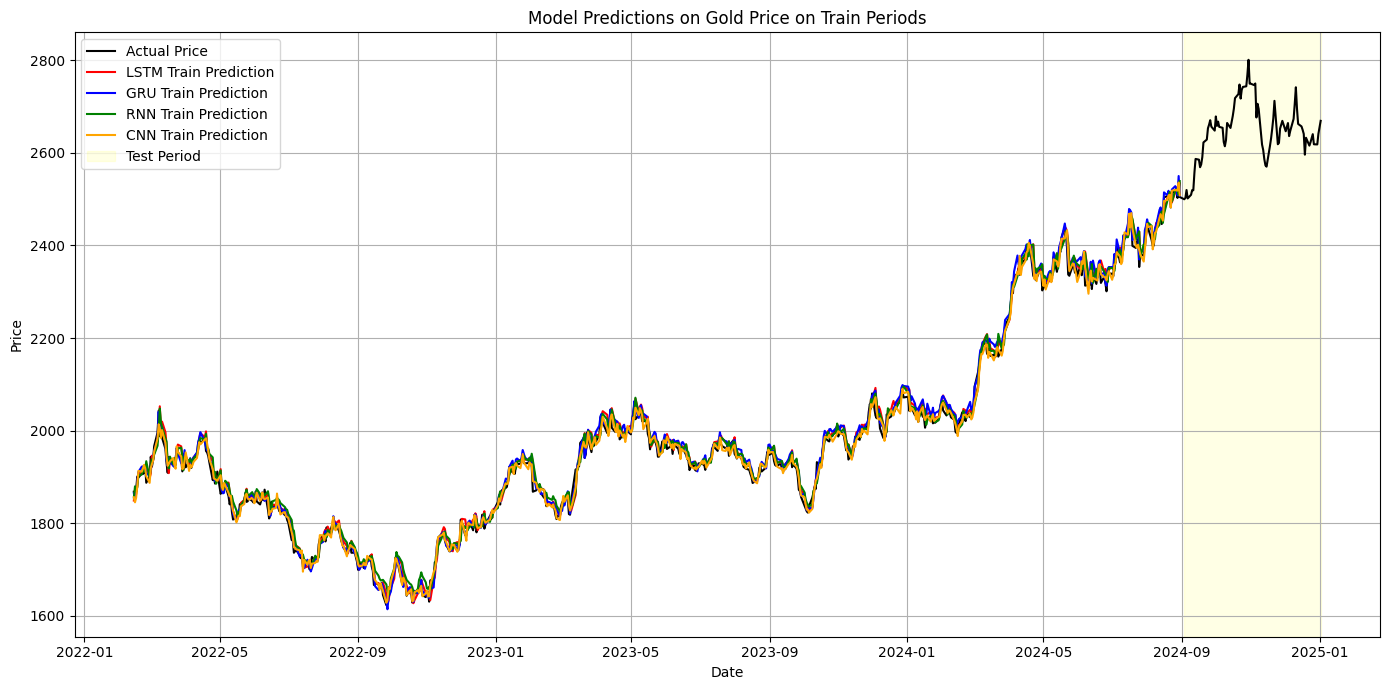

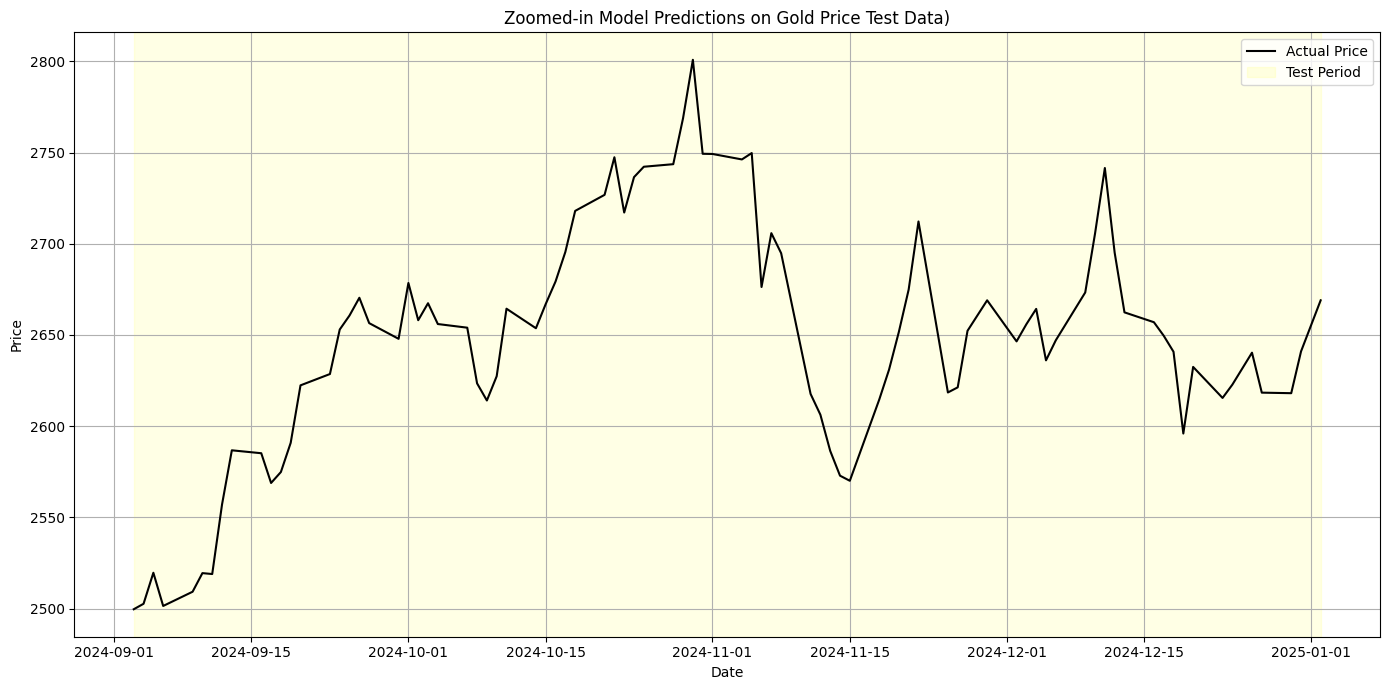

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # Ensure F is imported for activation functions
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import matplotlib.dates as mdates

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# Load and prepare data
df = pd.read_csv('Gold Futures Historical Data_3Yr.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Transform columns to numerical format
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')

# Check for duplicates and nulls
assert df.duplicated().sum() == 0, "Duplicate rows found!"
assert df.isnull().sum().sum() == 0, "Missing values found!"

# Features to include
features = ['Price', 'Open', 'High', 'Low']
data = df[features].values

# Data scaling (scale each feature individually)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Window width
window_width = 30  # Adjusted window width for experimentation

# Prepare sequences and corresponding dates
X, y, dates = [], [], []
for i in range(window_width, len(data_scaled)):
    X.append(data_scaled[i - window_width:i])
    y.append(data_scaled[i, 0])  # Assuming 'Price' is the target
    dates.append(df['Date'].iloc[i])

X = np.array(X)
y = np.array(y)
dates = np.array(dates)

# Ensure that dates and y have the same length
assert len(dates) == len(y), "Mismatch between dates and y lengths"

# Split the data into training, validation, and test sets based on dates
train_mask = dates < pd.to_datetime('2024-09-01')
#val_mask = (dates >= pd.to_datetime('2018-10-24')) & (dates < pd.to_datetime('2018-11-28'))
test_mask = dates >= pd.to_datetime('2024-09-01')

X_train, y_train = X[train_mask], y[train_mask]
#X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

train_dates = dates[train_mask]
#val_dates = dates[val_mask]
test_dates = dates[test_mask]

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
#X_val_tensor = torch.from_numpy(X_val).float()
#y_val_tensor = torch.from_numpy(y_val).float().unsqueeze(1)
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
#val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 32  # Adjusted batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # Set shuffle=False for sequential data
#val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### All the above are the data cleaning and preparation steps ### 


# Define the models
class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM'):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                nonlinearity='relu',
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'CNN':
            self.conv1 = nn.Conv1d(in_channels=len(features), out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            # Calculate the output size after Conv1d layers
            # Each Conv1d layer reduces the sequence length by (kernel_size - 1)
            conv_output_length = window_width - 2 * (3 - 1)  # Two Conv1d layers with kernel_size=3
            self.fc = nn.Linear(128 * conv_output_length, 1)

        else:
            raise ValueError("Invalid model_type. Choose 'LSTM', 'GRU', 'RNN', 'CNN', or 'EnhancedLSTM'.")

    def forward(self, x):
        if self.model_type == 'CNN':
            x = x.permute(0, 2, 1)  # Reshape for Conv1d: (batch_size, channels, seq_length)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        
        else:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        return out

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
            
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Define the inverse_transform function globally
def inverse_transform(y_scaled):
    """
    Inverse transform the scaled 'Price' values back to the original scale.
    Assumes that the scaler was fit on all features.
    """
    y_scaled = np.array(y_scaled).reshape(-1, 1)
    # Create a placeholder for other features with zeros
    zeros = np.zeros((y_scaled.shape[0], len(features) - 1))
    y_combined = np.hstack((y_scaled, zeros))
    y_inv = scaler.inverse_transform(y_combined)
    return y_inv[:, 0]

# Function to train and evaluate a model
def train_and_evaluate(model_name):
    # Initialize the model
    model = BaseModel(model_type=model_name).to(device)
    
    # Define the criterion, optimizer, and scheduler
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=150)
    
    # Early stopping
    early_stopping = EarlyStopping(patience=150, min_delta=0)
    num_epochs = 100
    #best_val_loss = float('inf')
    best_train_loss = float('inf')
    
    # Lists to store loss history
    train_losses_per_epoch = []
    #val_losses_per_epoch = []
    
    # Path to save the best model checkpoint
    best_model_path = f'best_model_{model_name}.pt'
    
    # Check if a saved model exists and load it
    if os.path.exists(best_model_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            model.load_state_dict(torch.load(best_model_path, map_location=device))
        print(f"Loaded existing model for {model_name} from {best_model_path}")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        train_losses_per_epoch.append(avg_train_loss)
        
        
        # Scheduler step
        scheduler.step(avg_train_loss)
        
        # Check for early stopping
        early_stopping(avg_train_loss)
        if early_stopping.early_stop:
            print(f"[{model_name}] Early stopping at epoch {epoch + 1}")
            break
        
        # Save the best model
        if avg_train_loss < best_train_loss:
            best_train_loss = avg_train_loss
            torch.save(model.state_dict(), best_model_path)
        
        # Print losses every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f'[{model_name}] Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.6f}')
    
    # Load the best model state
    model.load_state_dict(torch.load(best_model_path, weights_only=True))
    
    
    # Inverse scaling
    #y_val_pred_inv = inverse_transform(y_val_pred)

    # Generate training predictions
    model.eval()
    y_train_pred_list = []
    for X_batch, _ in train_loader:
        X_batch = X_batch.to(device)
        with torch.no_grad():
            preds = model(X_batch)
        y_train_pred_list.append(preds.cpu().numpy())
    y_train_pred = np.concatenate(y_train_pred_list)
    y_train_pred_inv = inverse_transform(y_train_pred)


    # Store results
    results = {
        'model_name': model_name,
        #'val_dates': val_dates,
        'test_dates': test_dates,
        'train_dates': train_dates,  # added
        'y_train_pred_inv': y_train_pred_inv,  # added
        'train_losses_per_epoch': train_losses_per_epoch,
        #'val_losses_per_epoch': val_losses_per_epoch,
    }

    return results

# List of models to train
model_names = ['LSTM', 'GRU', 'RNN', 'CNN',]

# Dictionary to store results
all_results = {}
    
# Train and evaluate each model
for model_name in model_names:
    print(f"\nTraining {model_name} model...")
    results = train_and_evaluate(model_name)
    all_results[model_name] = results

# Inverse transform the actual validation and test target values
#y_val_inv = inverse_transform(y_val_tensor.numpy())
y_train_pred_inv = inverse_transform(y_train_tensor.numpy())
y_test_inv = inverse_transform(y_test_tensor.numpy())

# Colors for different models
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
}

# Plotting the full dataset with predictions over validation and test sets only
plt.figure(figsize=(14, 7))

# Actual Price
plt.plot(dates, inverse_transform(y), color='black', label='Actual Price')

# Plot predicted data for each model over validation and test datasets only
for model_name, results in all_results.items():

    # Plot test predictions
    plt.plot(
        results['train_dates'],
        results['y_train_pred_inv'],
        color=model_colors[model_name],
        linestyle='-',
        label=f'{model_name} Train Prediction'
    )

# Highlight validation and test periods

plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')

plt.title('Model Predictions on Gold Price on Train Periods')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Zoomed-in plot for validation and test data with dashed lines for models
plt.figure(figsize=(14, 7))

# Combine validation and test dates and actual prices
zoom_dates = test_dates
zoom_actual = y_test_inv

# Plot actual prices for validation and test periods
plt.plot(
    zoom_dates,
    zoom_actual,
    color='black',
    label='Actual Price'
)


# Highlight validation and test periods

plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')

plt.title('Zoomed-in Model Predictions on Gold Price Test Data)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[LSTM] Epoch 1/100, Training Loss: 0.011975
[LSTM] Epoch 100/100, Training Loss: 0.000308


/tmp/ipykernel_1255066/1717226150.py:208: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


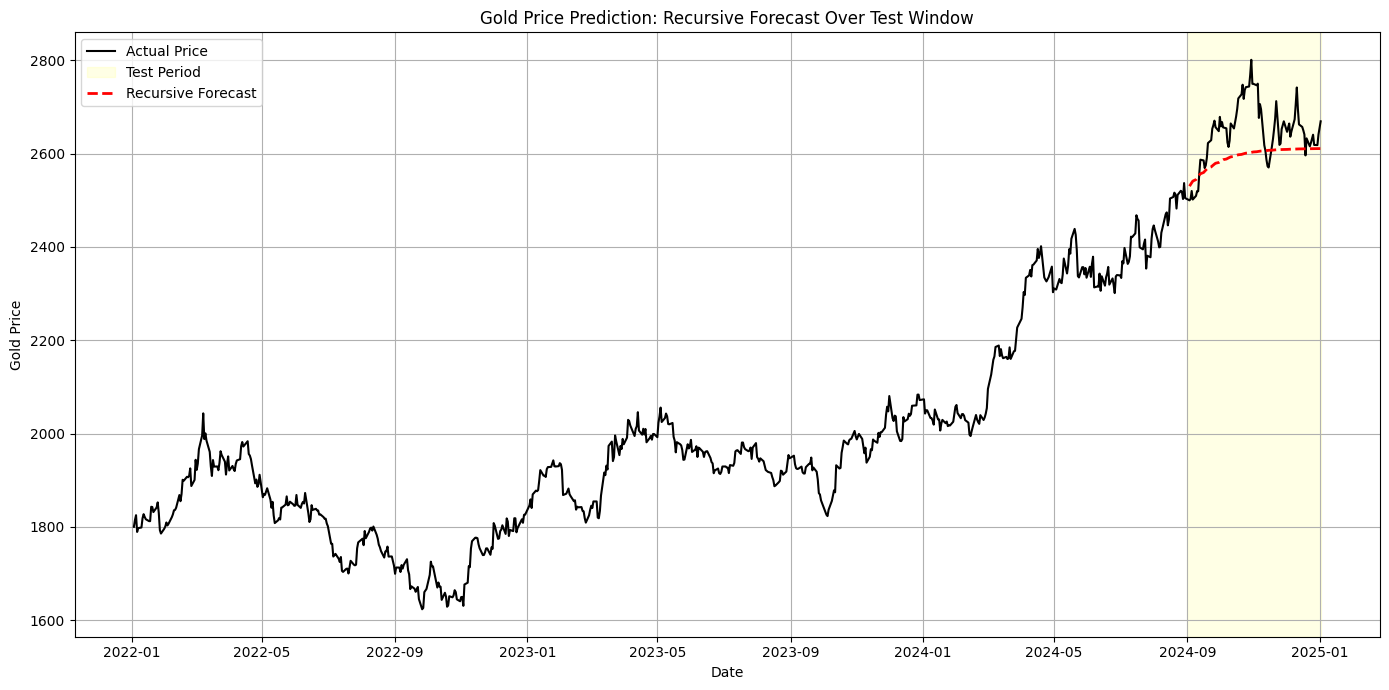

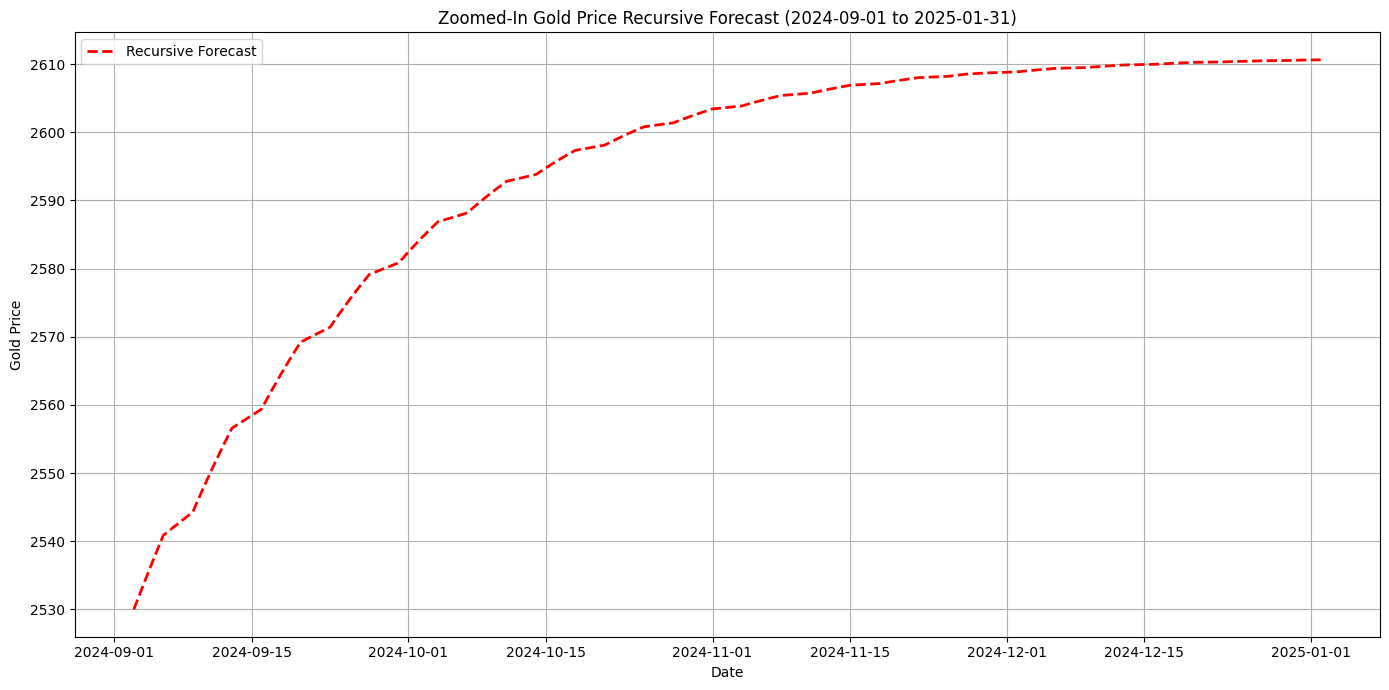

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # For activation functions
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import matplotlib.dates as mdates

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

### DATA LOADING, CLEANING, AND PREPARATION ###
# Load and prepare data
df = pd.read_csv('Gold Futures Historical Data_3Yr.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Transform columns to numerical format
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')

# Check for duplicates and nulls
assert df.duplicated().sum() == 0, "Duplicate rows found!"
assert df.isnull().sum().sum() == 0, "Missing values found!"

# Features to include
features = ['Price', 'Open', 'High', 'Low']
data = df[features].values

# Data scaling: scale all four features using MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Window width (number of past days used for prediction)
window_width = 30  # adjust as needed

# Prepare sequences:
# For each sample, we take the previous window_width days as input,
# and use the entire 4-dim vector of the day immediately following as the target.
X, y, all_dates = [], [], []
for i in range(window_width, len(data_scaled)):
    X.append(data_scaled[i - window_width:i])   # shape: (window_width, 4)
    y.append(data_scaled[i])                      # target: 4-dimensional vector
    all_dates.append(df['Date'].iloc[i])

X = np.array(X)  # shape: (num_samples, window_width, 4)
y = np.array(y)  # shape: (num_samples, 4)
all_dates = np.array(all_dates)

# Split data into training and test sets based on date.
# Training: all dates before 2024-09-01, Test: from 2024-09-01 onward.
train_mask = all_dates < pd.to_datetime('2024-09-01')
test_mask  = all_dates >= pd.to_datetime('2024-09-01')

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test   = X[test_mask], y[test_mask]
train_dates = all_dates[train_mask]
test_dates  = all_dates[test_mask]

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()  # shape: (N, 4)
X_test_tensor  = torch.from_numpy(X_test).float()
y_test_tensor  = torch.from_numpy(y_test).float()

# Create TensorDatasets and DataLoaders (for training only)
batch_size = 32  # adjust as needed
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # keep sequential order

### MODEL DEFINITION ###
# Modify the model so that its final layer outputs 4 values (for the 4 features).
class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM'):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        input_size = len(features)  # 4 features
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, input_size)  # output 4 values
        elif model_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=input_size,
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, input_size)
        elif model_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=input_size,
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                nonlinearity='relu',
                dropout=0.1,
            )
            self.fc = nn.Linear(128, input_size)
        elif model_type == 'CNN':
            self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            conv_output_length = window_width - 2 * (3 - 1)
            self.fc = nn.Linear(128 * conv_output_length, input_size)
        else:
            raise ValueError("Invalid model_type. Choose 'LSTM', 'GRU', 'RNN', or 'CNN'.")

    def forward(self, x):
        if self.model_type == 'CNN':
            # x shape: (batch, window_width, 4) -> (batch, 4, window_width)
            x = x.permute(0, 2, 1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        else:
            # x shape: (batch, window_width, 4)
            out, _ = self.rnn(x)
            out = out[:, -1, :]  # take output at last time step
            out = self.fc(out)
        return out  # shape: (batch, 4)

### EARLY STOPPING CLASS ###
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
            
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

### TRAINING FUNCTION ###
def train_and_evaluate(model_name):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BaseModel(model_type=model_name).to(device)
    
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=150)
    early_stopping = EarlyStopping(patience=150, min_delta=0)
    num_epochs = 100
    best_train_loss = float('inf')
    
    # Use a new checkpoint filename to avoid loading incompatible weights.
    best_model_path = f'best_model_{model_name}_4d.pt'
    
    # Load existing model if available
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path, map_location=device))
        print(f"Loaded existing model for {model_name} from {best_model_path}")
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        scheduler.step(avg_train_loss)
        early_stopping(avg_train_loss)
        if early_stopping.early_stop:
            print(f"[{model_name}] Early stopping at epoch {epoch + 1}")
            break
        if avg_train_loss < best_train_loss:
            best_train_loss = avg_train_loss
            torch.save(model.state_dict(), best_model_path)
        if (epoch + 1) % 100 == 0 or epoch == 0:
            print(f'[{model_name}] Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.6f}')
    
    # Load the best model
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    return model

### RECURSIVE FORECASTING FUNCTION ###
def recursive_forecast(model, initial_window, forecast_horizon, device):
    """
    Recursively predict the next 'forecast_horizon' days.
    
    Parameters:
        model: trained model.
        initial_window: a torch.Tensor of shape (window_width, 4) representing the last known window.
        forecast_horizon: number of days to forecast.
        device: torch device.
        
    Returns:
        predictions: a NumPy array of shape (forecast_horizon, 4) containing the forecasted values.
    """
    model.eval()
    preds = []
    current_window = initial_window.clone().to(device)  # shape: (window_width, 4)
    for _ in range(forecast_horizon):
        input_tensor = current_window.unsqueeze(0)  # shape: (1, window_width, 4)
        with torch.no_grad():
            pred = model(input_tensor)  # shape: (1, 4)
        pred = pred.squeeze(0)  # shape: (4,)
        preds.append(pred.cpu().numpy())
        # Form next window: remove the first row and append the new prediction row.
        current_window = torch.cat((current_window[1:], pred.unsqueeze(0)), dim=0)
    return np.array(preds)  # shape: (forecast_horizon, 4)

### TRAIN THE MODEL ###
# For illustration, we train (or load) an LSTM model.
model_name = 'LSTM'
model = train_and_evaluate(model_name)

### RECURSIVE FORECASTING FOR THE TEST WINDOW ###
# Use the last training window (from X_train_tensor) as the initial window.
initial_window = X_train_tensor[-1]  # shape: (window_width, 4)
forecast_horizon = len(test_dates)     # forecast for each day in the test period
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Obtain recursive forecasts (scaled values)
test_preds_scaled = recursive_forecast(model, initial_window, forecast_horizon, device)

# Inverse transform the forecasted 4‑vectors to the original scale.
# scaler.inverse_transform expects a 2D array where each row is a 4‑vector.
test_preds_inv = scaler.inverse_transform(test_preds_scaled)

# For plotting the gold price predictions, we take the first column (Price)
predicted_prices = test_preds_inv[:, 0]

### PLOTTING RESULTS ###
# Plot the entire dataset along with the recursive forecast (only the test window is based solely on predictions)
plt.figure(figsize=(14, 7))
# Plot actual prices (inverse transformed) for all dates
all_prices_inv = scaler.inverse_transform(data_scaled)[:, 0]
plt.plot(df['Date'], all_prices_inv, color='black', label='Actual Price')
# Highlight the test period
plt.axvspan(pd.to_datetime('2024-09-01'), df['Date'].iloc[-1], color='yellow', alpha=0.1, label='Test Period')
# Plot the recursive forecast over the test period
plt.plot(test_dates, predicted_prices, color='red', linestyle='--', linewidth=2, label='Recursive Forecast')
plt.title('Gold Price Prediction: Recursive Forecast Over Test Window')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Zoomed-in Plot (starting from 2024-09-01)
plt.figure(figsize=(14, 7))
plt.plot(test_dates, predicted_prices, color='red', linestyle='--', linewidth=2, label='Recursive Forecast')
plt.title('Zoomed-In Gold Price Recursive Forecast (2024-09-01 to 2025-01-31)')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Training and forecasting with model: LSTM
[LSTM] Epoch 1/300, Training Loss: 0.011237
[LSTM] Epoch 100/300, Training Loss: 0.000306
[LSTM] Epoch 200/300, Training Loss: 0.000143
[LSTM] Epoch 300/300, Training Loss: 0.000104

Training and forecasting with model: GRU
[GRU] Epoch 1/300, Training Loss: 0.007030


/tmp/ipykernel_1255066/1123954181.py:219: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[GRU] Epoch 100/300, Training Loss: 0.000166
[GRU] Epoch 200/300, Training Loss: 0.000108
[GRU] Epoch 300/300, Training Loss: 0.000129

Training and forecasting with model: RNN
[RNN] Epoch 1/300, Training Loss: 0.015308


/tmp/ipykernel_1255066/1123954181.py:219: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[RNN] Epoch 100/300, Training Loss: 0.000694
[RNN] Epoch 200/300, Training Loss: 0.000198
[RNN] Epoch 300/300, Training Loss: 0.000204

Training and forecasting with model: CNN
[CNN] Epoch 1/300, Training Loss: 0.003663


/tmp/ipykernel_1255066/1123954181.py:219: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[CNN] Epoch 100/300, Training Loss: 0.000442
[CNN] Epoch 200/300, Training Loss: 0.000107
[CNN] Epoch 300/300, Training Loss: 0.000086


/tmp/ipykernel_1255066/1123954181.py:219: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


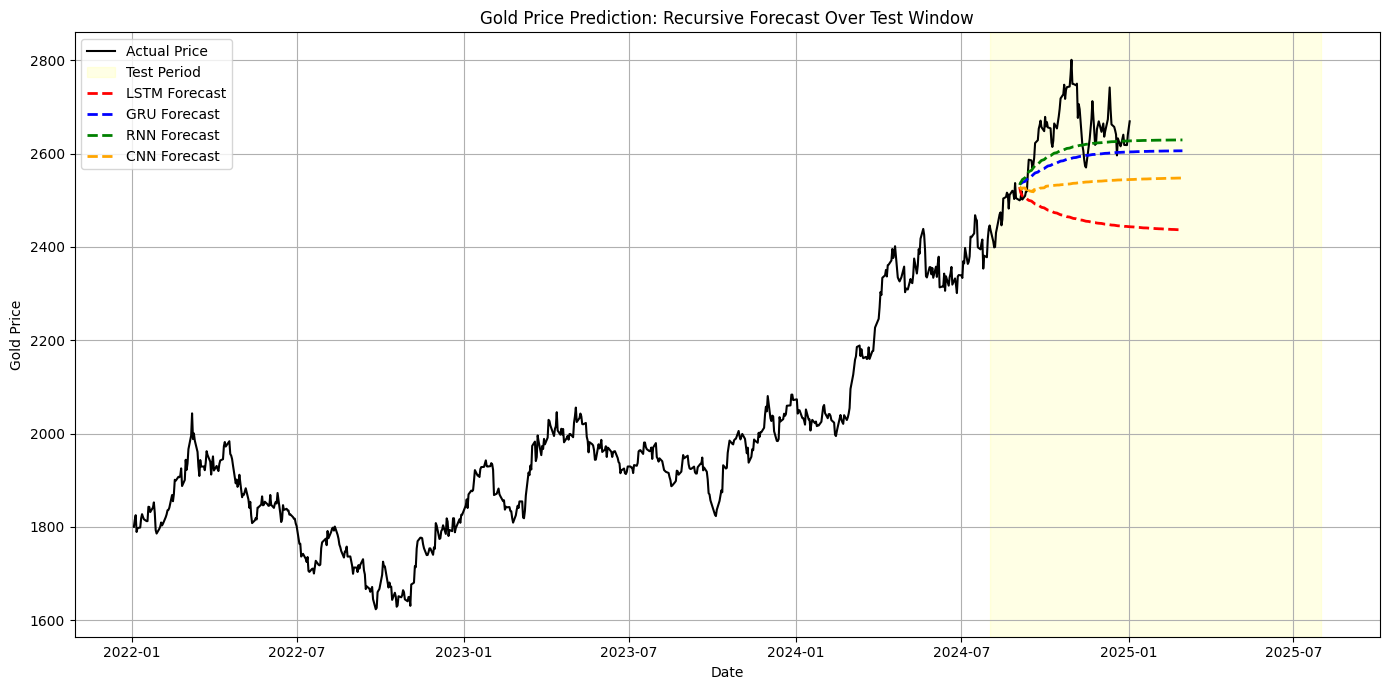

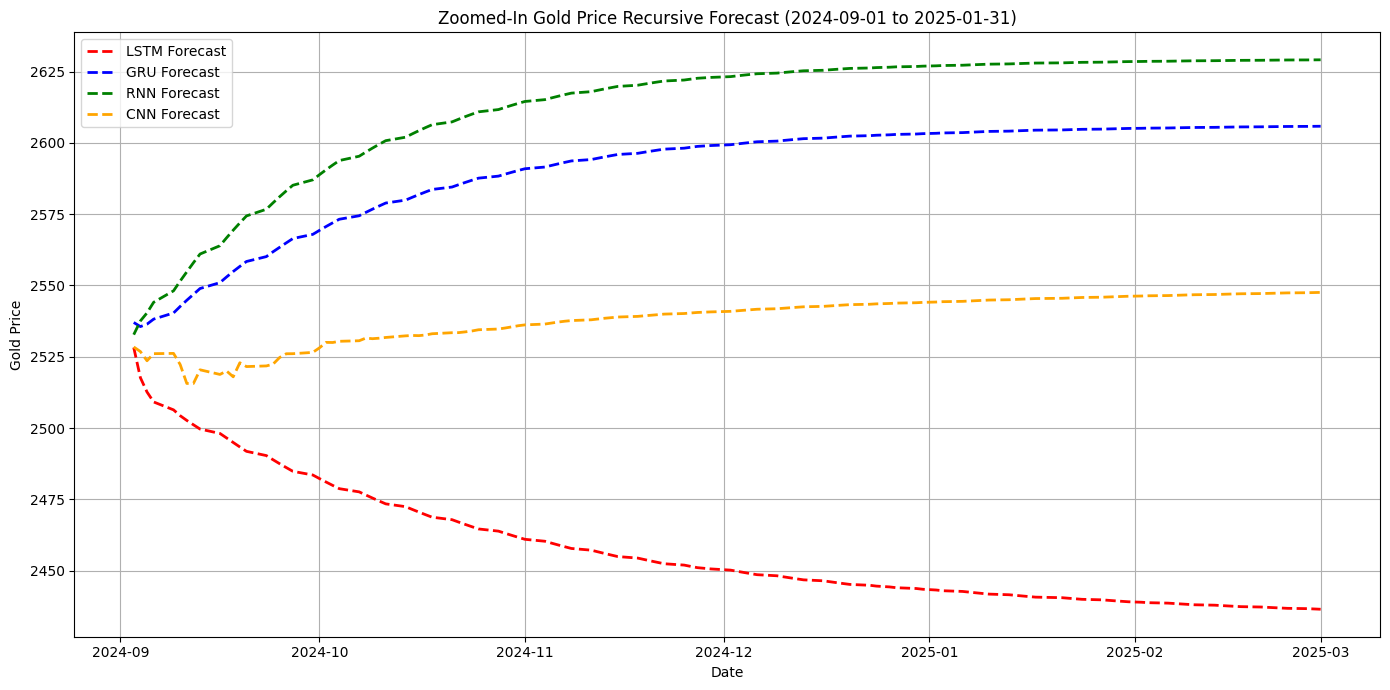

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # For activation functions
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import matplotlib.dates as mdates

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

### DATA LOADING, CLEANING, AND PREPARATION ###
df = pd.read_csv('Gold Futures Historical Data_3Yr.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Transform columns to numerical format
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')

# Check for duplicates and nulls
#assert df.duplicated().sum() == 0, "Duplicate rows found!"
#assert df.isnull().sum().sum() == 0, "Missing values found!"

# Features to include
features = ['Price', 'Open', 'High', 'Low']
data = df[features].values

# Data scaling: scale all four features using MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Window width (number of past days used for prediction)
window_width = 18  # adjust as needed

# Prepare sequences:
# For each sample, we take the previous window_width days as input,
# and use the entire 4‑dimensional vector of the day immediately following as the target.
X, y, all_dates = [], [], []
for i in range(window_width, len(data_scaled)):
    X.append(data_scaled[i - window_width:i])   # shape: (window_width, 4)
    y.append(data_scaled[i])                      # target: 4-dimensional vector
    all_dates.append(df['Date'].iloc[i])

X = np.array(X)  # shape: (num_samples, window_width, 4)
y = np.array(y)  # shape: (num_samples, 4)
all_dates = np.array(all_dates)

# Split data into training and test sets based on date.
# Training: all dates before 2024-09-01; Test: from 2024-09-01 onward.
train_mask = all_dates < pd.to_datetime('2024-09-01')
#test_mask  = all_dates >= pd.to_datetime('2025-01-01')
test_mask   = (all_dates >= pd.to_datetime('2024-09-01')) & (all_dates <= pd.to_datetime('2025-03-01'))

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test   = X[test_mask], y[test_mask]
train_dates = all_dates[train_mask]
test_dates  = all_dates[test_mask]

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()  # shape: (N, 4)
X_test_tensor  = torch.from_numpy(X_test).float()
y_test_tensor  = torch.from_numpy(y_test).float()

# Create TensorDatasets and DataLoaders (for training only)
batch_size = 32  # adjust as needed
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # sequential order

### MODEL DEFINITION ###
# The model is modified so that its final layer outputs 4 values.
class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM'):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        input_size = len(features)  # 4 features
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, input_size)  # output 4 values
        elif model_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=input_size,
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, input_size)
        elif model_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=input_size,
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                nonlinearity='relu',
                dropout=0.1,
            )
            self.fc = nn.Linear(128, input_size)
        elif model_type == 'CNN':
            self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            conv_output_length = window_width - 2 * (3 - 1)
            self.fc = nn.Linear(128 * conv_output_length, input_size)
        elif model_type == 'EnhancedLSTM':
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=128,
                num_layers=3,
                batch_first=True,
                dropout=0.2,
            )
            self.dropout = nn.Dropout(0.2)
            self.bn = nn.BatchNorm1d(128)
            self.fc = nn.Linear(128, input_size)
        else:
            raise ValueError("Invalid model_type. Choose from 'LSTM', 'GRU', 'RNN', 'CNN'")

    def forward(self, x):
        if self.model_type == 'CNN':
            # x shape: (batch, window_width, 4) -> (batch, 4, window_width)
            x = x.permute(0, 2, 1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)

        else:
            # For LSTM, GRU, and RNN:
            out, _ = self.rnn(x)
            out = out[:, -1, :]  # last time step output
            out = self.fc(out)
        return out  # shape: (batch, 4)

### EARLY STOPPING CLASS ###
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
            
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

### TRAINING FUNCTION ###
def train_and_evaluate(model_name):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BaseModel(model_type=model_name).to(device)
    
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=150)
    early_stopping = EarlyStopping(patience=150, min_delta=0)
    num_epochs = 1500
    best_train_loss = float('inf')
    
    # Use a new checkpoint filename to avoid loading incompatible weights.
    best_model_path = f'best_model_{model_name}_4d.pt'
    
    # Load existing model if available
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path, map_location=device))
        print(f"Loaded existing model for {model_name} from {best_model_path}")
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        scheduler.step(avg_train_loss)
        early_stopping(avg_train_loss)
        if early_stopping.early_stop:
            print(f"[{model_name}] Early stopping at epoch {epoch + 1}")
            break
        if avg_train_loss < best_train_loss:
            best_train_loss = avg_train_loss
            torch.save(model.state_dict(), best_model_path)
        if (epoch + 1) % 100 == 0 or epoch == 0:
            print(f'[{model_name}] Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.6f}')
    
    # Load the best model
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    return model

### RECURSIVE FORECASTING FUNCTION ###
def recursive_forecast(model, initial_window, forecast_horizon, device):
    """
    Recursively predict the next 'forecast_horizon' days.
    
    Parameters:
        model: trained model.
        initial_window: a torch.Tensor of shape (window_width, 4) representing the last known window.
        forecast_horizon: number of days to forecast.
        device: torch device.
        
    Returns:
        predictions: a NumPy array of shape (forecast_horizon, 4) containing the forecasted values.
    """
    model.eval()
    preds = []
    current_window = initial_window.clone().to(device)  # shape: (window_width, 4)
    for _ in range(forecast_horizon):
        input_tensor = current_window.unsqueeze(0)  # shape: (1, window_width, 4)
        with torch.no_grad():
            pred = model(input_tensor)  # shape: (1, 4)
        pred = pred.squeeze(0)  # shape: (4,)
        preds.append(pred.cpu().numpy())
        # Form next window: remove the first row and append the new prediction row.
        current_window = torch.cat((current_window[1:], pred.unsqueeze(0)), dim=0)
    return np.array(preds)  # shape: (forecast_horizon, 4)

### TRAIN AND FORECAST WITH MULTIPLE MODELS ###
model_names = ['LSTM', 'GRU', 'RNN', 'CNN']
all_forecasts = {}  # dictionary to store forecasted prices (first column) for each model

for model_name in model_names:
    print(f"\nTraining and forecasting with model: {model_name}")
    model = train_and_evaluate(model_name)
    # Use the last training window as the initial window for recursive forecasting.
    initial_window = X_train_tensor[-1]  # shape: (window_width, 4)
    forecast_horizon = len(test_dates)     # forecast for each day in the test period
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    test_preds_scaled = recursive_forecast(model, initial_window, forecast_horizon, device)
    test_preds_inv = scaler.inverse_transform(test_preds_scaled)
    predicted_prices = test_preds_inv[:, 0]  # take the predicted 'Price' (first column)
    all_forecasts[model_name] = predicted_prices

### PLOTTING RESULTS ###
# Plot the entire dataset along with the recursive forecast from each model over the test window.
plt.figure(figsize=(14, 7))
# Plot actual prices (inverse transformed) for all dates.
all_prices_inv = scaler.inverse_transform(data_scaled)[:, 0]
plt.plot(df['Date'], all_prices_inv, color='black', label='Actual Price')
# Highlight the test period.
plt.axvspan(pd.to_datetime('2024-08-01'), df['Date'].iloc[-1], color='yellow', alpha=0.1, label='Test Period')
# Define colors for models.
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
}
# Plot forecast from each model.
for model_name, forecast in all_forecasts.items():
    plt.plot(test_dates, forecast, color=model_colors[model_name], linestyle='--', linewidth=2, label=f'{model_name} Forecast')
plt.title('Gold Price Prediction: Recursive Forecast Over Test Window')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Zoomed-in Plot (starting from 2024-09-01)
plt.figure(figsize=(14, 7))
for model_name, forecast in all_forecasts.items():
    plt.plot(test_dates, forecast, color=model_colors[model_name], linestyle='--', linewidth=2, label=f'{model_name} Forecast')
plt.title('Zoomed-In Gold Price Recursive Forecast (2024-09-01 to 2025-01-31)')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # for activation functions
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import matplotlib.dates as mdates

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

### 1. DATA LOADING, CLEANING, AND PREPARATION ###

# Load and prepare data
df = pd.read_csv('Gold Futures Historical Data_3Yr.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Convert numeric columns
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')

# Check for duplicates and missing values
#assert df.duplicated().sum() == 0, "Duplicate rows found!"
#assert df.isnull().sum().sum() == 0, "Missing values found!"

# Features to include
features = ['Price', 'Open', 'High', 'Low']
data = df[features].values

# Scale all four features using MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Window width: number of past days used as input
window_width = 30

# Prepare sequences.
# For each sample, use the previous `window_width` days as input and
# the entire 4-dimensional vector (Price, Open, High, Low) for the next day as target.
X, y, all_dates = [], [], []
for i in range(window_width, len(data_scaled)):
    X.append(data_scaled[i - window_width:i])  # shape: (window_width, 4)
    y.append(data_scaled[i])                     # target: 4-dimensional vector
    all_dates.append(df['Date'].iloc[i])
    
X = np.array(X)  # shape: (num_samples, window_width, 4)
y = np.array(y)  # shape: (num_samples, 4)
all_dates = np.array(all_dates)

# Split data into training, validation, and test sets based on the target date.
# Training: before 2024-05-01
# Validation: 2024-05-01 to 2024-08-31
# Test: from 2024-09-01 onward
train_mask = all_dates < pd.to_datetime('2024-07-01')
val_mask   = (all_dates >= pd.to_datetime('2024-07-01')) & (all_dates <= pd.to_datetime('2024-08-31'))
test_mask  = all_dates >= pd.to_datetime('2024-09-01')

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val     = X[val_mask], y[val_mask]
X_test, y_test   = X[test_mask], y[test_mask]
train_dates = all_dates[train_mask]
val_dates   = all_dates[val_mask]
test_dates  = all_dates[test_mask]

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()  # shape: (N_train, 4)
X_val_tensor   = torch.from_numpy(X_val).float()
y_val_tensor   = torch.from_numpy(y_val).float()    # shape: (N_val, 4)
X_test_tensor  = torch.from_numpy(X_test).float()
y_test_tensor  = torch.from_numpy(y_test).float()    # shape: (N_test, 4)

# Create TensorDatasets and DataLoaders (for training only)
batch_size = 32  # adjust as needed
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # keep sequential order

### 2. MODEL DEFINITION ###

# The BaseModel outputs 4 values from its final fully connected layer.
class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM'):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        input_size = len(features)  # 4 features
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, input_size)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=input_size,
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, input_size)
        elif model_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=input_size,
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                nonlinearity='relu',
                dropout=0.1,
            )
            self.fc = nn.Linear(128, input_size)
        elif model_type == 'CNN':
            self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            conv_output_length = window_width - 2 * (3 - 1)
            self.fc = nn.Linear(128 * conv_output_length, input_size)
        elif model_type == 'EnhancedLSTM':
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=128,
                num_layers=3,
                batch_first=True,
                dropout=0.2,
            )
            self.dropout = nn.Dropout(0.2)
            self.bn = nn.BatchNorm1d(128)
            self.fc = nn.Linear(128, input_size)
        else:
            raise ValueError("Invalid model_type. Choose from 'LSTM', 'GRU', 'RNN', 'CNN', or 'EnhancedLSTM'.")

    def forward(self, x):
        if self.model_type == 'CNN':
            # reshape: (batch, window_width, 4) -> (batch, 4, window_width)
            x = x.permute(0, 2, 1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type == 'EnhancedLSTM':
            out, _ = self.rnn(x)
            out = out[:, -1, :]  # take last time step
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        else:
            out, _ = self.rnn(x)
            out = out[:, -1, :]  # last time step output
            out = self.fc(out)
        return out  # shape: (batch, 4)

### 3. EARLY STOPPING CLASS ###
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
            
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

### 4. RECURSIVE FORECASTING FUNCTION ###
def recursive_forecast(model, initial_window, forecast_horizon, device):
    """
    Recursively predict the next 'forecast_horizon' days.
    
    Parameters:
        model: trained model.
        initial_window: torch.Tensor of shape (window_width, 4) representing the last known window.
        forecast_horizon: number of days to forecast.
        device: torch device.
        
    Returns:
        predictions: NumPy array of shape (forecast_horizon, 4) with forecasted values.
    """
    model.eval()
    preds = []
    current_window = initial_window.clone().to(device)  # shape: (window_width, 4)
    for _ in range(forecast_horizon):
        input_tensor = current_window.unsqueeze(0)  # shape: (1, window_width, 4)
        with torch.no_grad():
            pred = model(input_tensor)  # shape: (1, 4)
        pred = pred.squeeze(0)  # shape: (4,)
        preds.append(pred.cpu().numpy())
        # Form next window: drop first row, append new prediction row.
        current_window = torch.cat((current_window[1:], pred.unsqueeze(0)), dim=0)
    return np.array(preds)  # shape: (forecast_horizon, 4)

### 5. TRAINING FUNCTION WITH VALIDATION ###
def train_and_evaluate(model_name, X_train_tensor, y_train_tensor, X_val_tensor, y_val, val_dates):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BaseModel(model_type=model_name).to(device)
    
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    # We will update the scheduler based on validation loss.
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=150)
    early_stopping = EarlyStopping(patience=150, min_delta=0)
    num_epochs = 800
    best_val_loss = float('inf')
    
    # Use a new checkpoint filename to avoid loading incompatible weights.
    best_model_path = f'best_model_{model_name}_4d.pt'
    
    # Load existing model if available
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path, map_location=device))
        print(f"Loaded existing model for {model_name} from {best_model_path}")
    
    for epoch in range(num_epochs):
        # ---- Training Phase ----
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        
        # ---- Validation Phase (Recursive Forecast) ----
        # Use the last training window as the seed.
        initial_window = X_train_tensor[-1]
        forecast_horizon_val = len(val_dates)
        val_preds_scaled = recursive_forecast(model, initial_window, forecast_horizon_val, device)
        # Inverse transform the predictions
        val_preds_inv = scaler.inverse_transform(val_preds_scaled)
        predicted_prices_val = val_preds_inv[:, 0]  # predicted Price
        
        # Actual validation targets: these are the targets from the sliding windows.
        # Since each sample’s target is a 4-vector, we take the first element.
        y_val_inv = scaler.inverse_transform(y_val)[:, 0]
        # Compute validation loss as MAPE (mean absolute percentage error)
        val_loss = np.mean(np.abs((y_val_inv - predicted_prices_val) / y_val_inv)) * 100
        
        scheduler.step(val_loss)
        early_stopping(val_loss)
        
        print(f"[{model_name}] Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.6f}, Val MAPE: {val_loss:.2f}%")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
        if early_stopping.early_stop:
            if (epoch + 1) % 100 == 0 or epoch == 0:
                print(f"[{model_name}] Early stopping triggered at epoch {epoch+1}")
            break
            
    # Load the best model
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    return model

### 6. TRAINING AND FORECASTING WITH MULTIPLE MODELS ###
model_names = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']
all_val_forecasts = {}   # store validation forecasts (Price) for each model
all_test_forecasts = {}  # store test forecasts (Price) for each model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for model_name in model_names:
    print(f"\nTraining and validating with model: {model_name}")
    model = train_and_evaluate(model_name, X_train_tensor, y_train_tensor, X_val_tensor, y_val, val_dates)
    
    # ---- Recursive Forecast on Validation Window ----
    initial_window = X_train_tensor[-1]  # use the last training window as seed
    forecast_horizon_val = len(val_dates)
    val_preds_scaled = recursive_forecast(model, initial_window, forecast_horizon_val, device)
    val_preds_inv = scaler.inverse_transform(val_preds_scaled)
    predicted_prices_val = val_preds_inv[:, 0]  # predicted Price
    all_val_forecasts[model_name] = predicted_prices_val
    
    # ---- Recursive Forecast on Test Window ----
    initial_window = X_train_tensor[-1]  # use the same seed (or you could use the last available window from validation if you wish)
    forecast_horizon_test = len(test_dates)
    test_preds_scaled = recursive_forecast(model, initial_window, forecast_horizon_test, device)
    test_preds_inv = scaler.inverse_transform(test_preds_scaled)
    predicted_prices_test = test_preds_inv[:, 0]  # predicted Price
    all_test_forecasts[model_name] = predicted_prices_test

### 7. PLOTTING RESULTS ###

# First, plot overall actual prices and forecasts over the validation and test periods.
plt.figure(figsize=(14, 7))
all_prices_inv = scaler.inverse_transform(data_scaled)[:, 0]
plt.plot(df['Date'], all_prices_inv, color='black', label='Actual Price')
# Highlight validation and test periods
plt.axvspan(pd.to_datetime('2024-05-01'), pd.to_datetime('2024-08-31'), color='yellow', alpha=0.1, label='Validation Period')
plt.axvspan(pd.to_datetime('2024-09-01'), df['Date'].iloc[-1], color='cyan', alpha=0.1, label='Test Period')

# Define colors for each model.
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
    'EnhancedLSTM': 'purple'
}

# Plot validation forecasts for each model.
for model_name, forecast in all_val_forecasts.items():
    plt.plot(val_dates, forecast, color=model_colors[model_name], linestyle='--', linewidth=2,
             label=f'{model_name} Val Forecast')
# Plot test forecasts for each model.
for model_name, forecast in all_test_forecasts.items():
    plt.plot(test_dates, forecast, color=model_colors[model_name], linestyle=':', linewidth=2,
             label=f'{model_name} Test Forecast')

plt.title('Gold Price Predictions: Actual vs. Recursive Forecasts (Validation & Test)')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Second, produce zoomed-in plots.
# Zoomed-in plot for Validation Period.
plt.figure(figsize=(14, 7))
plt.plot(val_dates, scaler.inverse_transform(y_val)[:, 0], color='black', label='Actual Price (Val)')
for model_name, forecast in all_val_forecasts.items():
    plt.plot(val_dates, forecast, color=model_colors[model_name], linestyle='--', linewidth=2,
             label=f'{model_name} Val Forecast')
plt.title('Zoomed-In: Gold Price Recursive Forecast (Validation: 2024-05-01 to 2024-08-31)')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Zoomed-in plot for Test Period.
plt.figure(figsize=(14, 7))
plt.plot(test_dates, scaler.inverse_transform(y_test)[:, 0], color='black', label='Actual Price (Test)')
for model_name, forecast in all_test_forecasts.items():
    plt.plot(test_dates, forecast, color=model_colors[model_name], linestyle=':', linewidth=2,
             label=f'{model_name} Test Forecast')
plt.title('Zoomed-In: Gold Price Recursive Forecast (Test: 2024-09-01 onward)')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Training model: LSTM
Epoch 1/50, Loss: 0.5190
Epoch 10/50, Loss: 0.0121
Epoch 20/50, Loss: 0.0097
Epoch 30/50, Loss: 0.0081
Epoch 40/50, Loss: 0.0069
Epoch 50/50, Loss: 0.0062

Training model: GRU
Epoch 1/50, Loss: 0.2846
Epoch 10/50, Loss: 0.0077
Epoch 20/50, Loss: 0.0061
Epoch 30/50, Loss: 0.0052
Epoch 40/50, Loss: 0.0049
Epoch 50/50, Loss: 0.0046

Training model: RNN
Epoch 1/50, Loss: 0.5653
Epoch 10/50, Loss: 0.0090
Epoch 20/50, Loss: 0.0084
Epoch 30/50, Loss: 0.0070
Epoch 40/50, Loss: 0.0075
Epoch 50/50, Loss: 0.0071

Training model: CNN
Epoch 1/50, Loss: 0.1909
Epoch 10/50, Loss: 0.0103
Epoch 20/50, Loss: 0.0074
Epoch 30/50, Loss: 0.0055
Epoch 40/50, Loss: 0.0052
Epoch 50/50, Loss: 0.0037

Training model: EnhancedLSTM
Epoch 1/50, Loss: 0.3119
Epoch 10/50, Loss: 0.0897
Epoch 20/50, Loss: 0.0416
Epoch 30/50, Loss: 0.0407
Epoch 40/50, Loss: 0.0396
Epoch 50/50, Loss: 0.0283


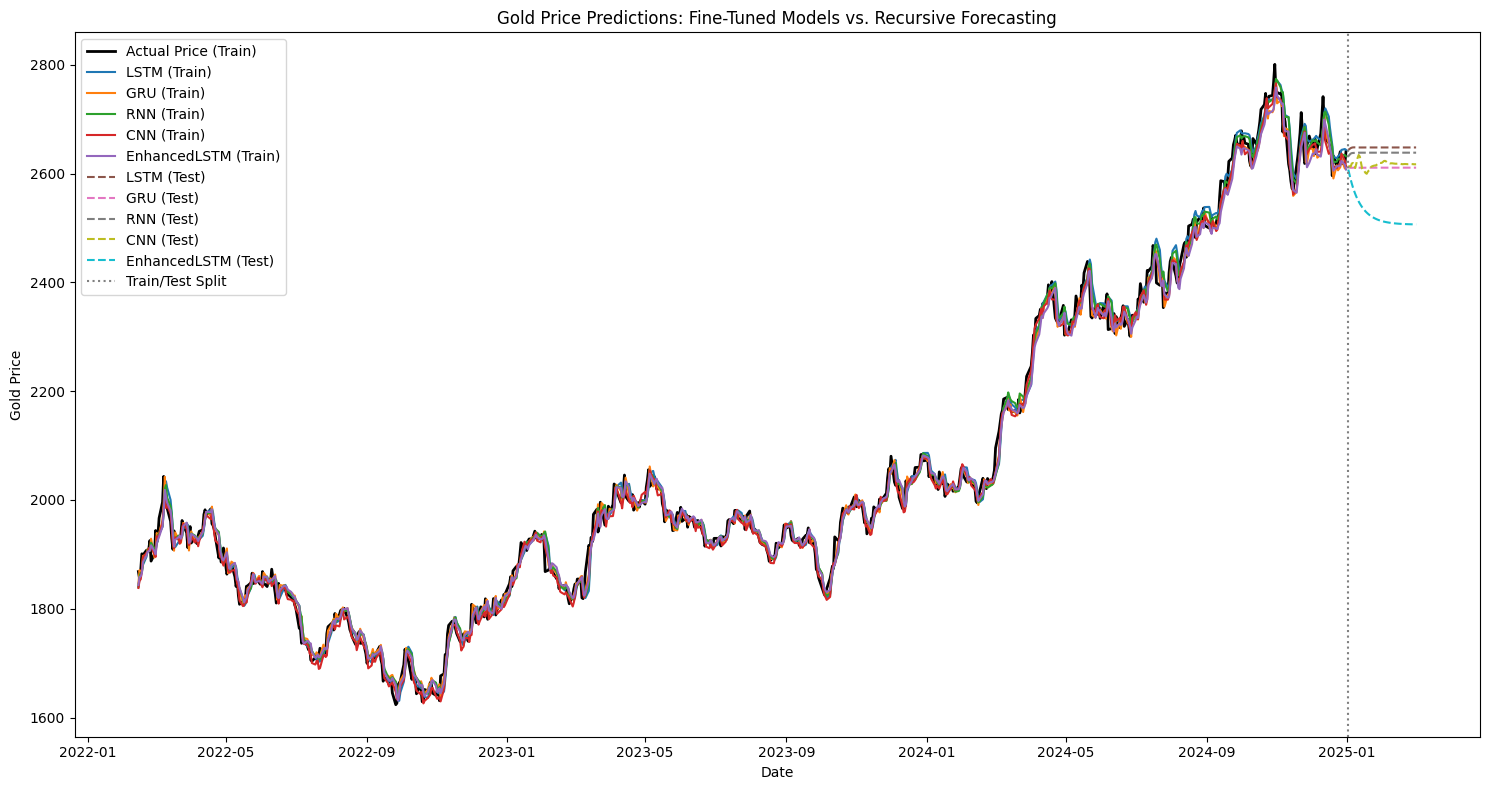

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# -------------------------------
# 1. Data Loading, Cleaning & Normalization
# -------------------------------
df = pd.read_csv('Gold Futures Historical Data_3Yr.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Remove commas from numeric columns and convert to float64
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')

# Note: We'll scale the features (including Price, Open, High, Low).
features = ['Price', 'Open', 'High', 'Low']
data_all = df[features].values

# Initialize the scaler and scale the data
scaler = StandardScaler()
data_all_scaled = scaler.fit_transform(data_all)

# -------------------------------
# 2. Splitting Data by Date
# -------------------------------
dates = df['Date']
# Define training period (up to 2025-01-02) and test period (2025-01-02 to 2025-01-31)
train_mask = dates < pd.to_datetime('2025-01-02')
# We only use training data for computing loss; test predictions are generated recursively.
train_data_scaled = data_all_scaled[train_mask.values]
train_dates = dates[train_mask].reset_index(drop=True)

# -------------------------------
# 3. Create Sequences for Training
# -------------------------------
# Using a sliding window approach: for each window (of length window_width),
# we predict the next day’s Price (the first column).
window_width = 30

def create_sequences(data, dates, window_size):
    sequences = []
    targets = []
    target_dates = []
    for i in range(len(data) - window_size):
        seq = data[i:i+window_size]
        target = data[i+window_size][0]  # predicting the scaled Price
        sequences.append(seq)
        targets.append(target)
        target_dates.append(dates.iloc[i+window_size])
    return np.array(sequences), np.array(targets), np.array(target_dates)

X_train, y_train, train_target_dates = create_sequences(train_data_scaled, train_dates, window_width)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # shape: (samples, window_width, num_features)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

# Create DataLoader
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# -------------------------------
# 4. Define Models (Fine-Tuned Versions)
# -------------------------------
class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM'):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        # We use the number of features from our (scaled) data.
        input_size = len(features)
        if model_type == 'LSTM':
            # For LSTM, we use two layers but no dropout.
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.0,  # removed dropout for faster convergence
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'GRU':
            # For GRU, similarly remove dropout.
            self.rnn = nn.GRU(
                input_size=input_size,
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.0,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=input_size,
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                nonlinearity='relu',
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'CNN':
            self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            conv_output_length = window_width - 2 * (3 - 1)
            self.fc = nn.Linear(128 * conv_output_length, 1)
        elif model_type == 'EnhancedLSTM':
            # For the enhanced version, we reduce dropout slightly and keep three layers.
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=128,
                num_layers=3,
                batch_first=True,
                dropout=0.1,  # reduced dropout compared to before
            )
            self.dropout = nn.Dropout(0.1)
            self.bn = nn.BatchNorm1d(128)
            self.fc = nn.Linear(128, 1)
        else:
            raise ValueError("Invalid model_type. Choose from 'LSTM', 'GRU', 'RNN', 'CNN', or 'EnhancedLSTM'.")

    def forward(self, x):
        if self.model_type == 'CNN':
            x = x.permute(0, 2, 1)  # (batch, channels, seq_len)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type == 'EnhancedLSTM':
            out, _ = self.rnn(x)
            out = out[:, -1, :]  # take the last time step
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        else:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        return out

# -------------------------------
# 5. Training Function with Scheduler, Early Stopping, & Gradient Clipping
# -------------------------------
def train_model(model, train_loader, epochs=50, lr=1e-3, patience=10, clip_norm=1.0):
    """
    Train the model with MSELoss, a learning rate scheduler, early stopping, and gradient clipping.
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    best_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            # Apply gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
            optimizer.step()
            epoch_loss += loss.item() * X_batch.size(0)
        epoch_loss /= len(train_loader.dataset)
        
        scheduler.step(epoch_loss)
        
        # Print every 10 epochs (or at first epoch)
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')
        
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"Early stopping after {epoch+1} epochs.")
            if best_model_state is not None:
                model.load_state_dict(best_model_state)
            break
            
    return model

# -------------------------------
# 6. Recursive Forecasting Function for the Test Window
# -------------------------------
def predict_future(model, initial_window, n_preds):
    """
    Recursively predict future (scaled) Price values.
    """
    preds = []
    current_window = initial_window.unsqueeze(0)
    model.eval()
    for _ in range(n_preds):
        with torch.no_grad():
            next_pred = model(current_window)  # shape: (1,1)
        next_value = next_pred.item()
        preds.append(next_value)
        last_row = current_window[0, -1, :].clone()
        last_row[0] = next_value
        new_window = torch.cat([current_window[0, 1:, :], last_row.unsqueeze(0)], dim=0)
        current_window = new_window.unsqueeze(0)
    return preds

# -------------------------------
# 7. Train Models and Generate Predictions
# -------------------------------
predictions_train = {}
predictions_test = {}
model_types = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']

# We'll forecast 60 time steps ahead
forecast_horizon = 120

# Train each model (here we use fewer epochs for illustration; adjust as needed)
for m_type in model_types:
    print(f"\nTraining model: {m_type}")
    model = BaseModel(model_type=m_type)
    model = train_model(model, train_loader, epochs=50, lr=1e-3, patience=10, clip_norm=1.0)
    
    # Evaluate on training set (predictions on sliding windows; these are scaled values)
    model.eval()
    with torch.no_grad():
        train_preds_scaled = model(X_train_tensor).squeeze().numpy()
    predictions_train[m_type] = train_preds_scaled

    # Recursive forecasting starting from the last training window
    last_train_window = X_train_tensor[-1]
    test_preds_scaled = predict_future(model, last_train_window, forecast_horizon)
    predictions_test[m_type] = test_preds_scaled

# -------------------------------
# 8. Inverse Transform Predictions and Plotting
# -------------------------------
# For plotting, we need to convert scaled Price values back to the original scale.
# The Price is the first column in our data; we use the corresponding scaler parameters.
# Note: We assume the same scaler was applied to all features.
def inverse_transform_price(scaled_values):
    # Create an array with shape (n,4) where the first column is scaled_values
    dummy = np.zeros((len(scaled_values), len(features)))
    dummy[:,0] = scaled_values
    inv = scaler.inverse_transform(dummy)
    return inv[:,0]

# Inverse-transform training targets and predictions
y_train_inv = inverse_transform_price(y_train)
predictions_train_inv = {m: inverse_transform_price(pred) for m, pred in predictions_train.items()}
predictions_test_inv = {m: inverse_transform_price(pred) for m, pred in predictions_test.items()}

plt.figure(figsize=(15, 8))
plt.plot(train_target_dates, y_train_inv, label='Actual Price (Train)', color='black', linewidth=2)

for m_type in model_types:
    plt.plot(train_target_dates, predictions_train_inv[m_type],
             label=f'{m_type} (Train)', linestyle='-')

test_start_date = pd.to_datetime('2025-01-02')
test_dates = pd.date_range(start=test_start_date, periods=forecast_horizon, freq='D')
for m_type in model_types:
    plt.plot(test_dates, predictions_test_inv[m_type],
             label=f'{m_type} (Test)', linestyle='--')

plt.axvline(test_start_date, color='gray', linestyle=':', label='Train/Test Split')
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.title("Gold Price Predictions: Fine-Tuned Models vs. Recursive Forecasting")
plt.legend()
plt.tight_layout()
plt.show()



Training model: LSTM
Epoch 1/150, Loss: 0.2087
Epoch 10/150, Loss: 0.0088
Epoch 20/150, Loss: 0.0077
Epoch 30/150, Loss: 0.0053
Epoch 40/150, Loss: 0.0055
Epoch 50/150, Loss: 0.0044
Epoch 60/150, Loss: 0.0040
Epoch 70/150, Loss: 0.0040
Epoch 80/150, Loss: 0.0040
Epoch 90/150, Loss: 0.0039
Epoch 100/150, Loss: 0.0039
Epoch 110/150, Loss: 0.0039
Epoch 120/150, Loss: 0.0039
Epoch 130/150, Loss: 0.0039
Epoch 140/150, Loss: 0.0039
Epoch 150/150, Loss: 0.0039

Training model: GRU
Epoch 1/150, Loss: 0.1102
Epoch 10/150, Loss: 0.0056
Epoch 20/150, Loss: 0.0048
Epoch 30/150, Loss: 0.0048
Epoch 40/150, Loss: 0.0042
Epoch 50/150, Loss: 0.0040
Epoch 60/150, Loss: 0.0040
Epoch 70/150, Loss: 0.0040
Epoch 80/150, Loss: 0.0040
Epoch 90/150, Loss: 0.0039
Epoch 100/150, Loss: 0.0039
Epoch 110/150, Loss: 0.0039
Epoch 120/150, Loss: 0.0039
Epoch 130/150, Loss: 0.0039
Epoch 140/150, Loss: 0.0039
Epoch 150/150, Loss: 0.0039

Training model: RNN
Epoch 1/150, Loss: 0.2231
Epoch 10/150, Loss: 0.0071
Epoch 20/

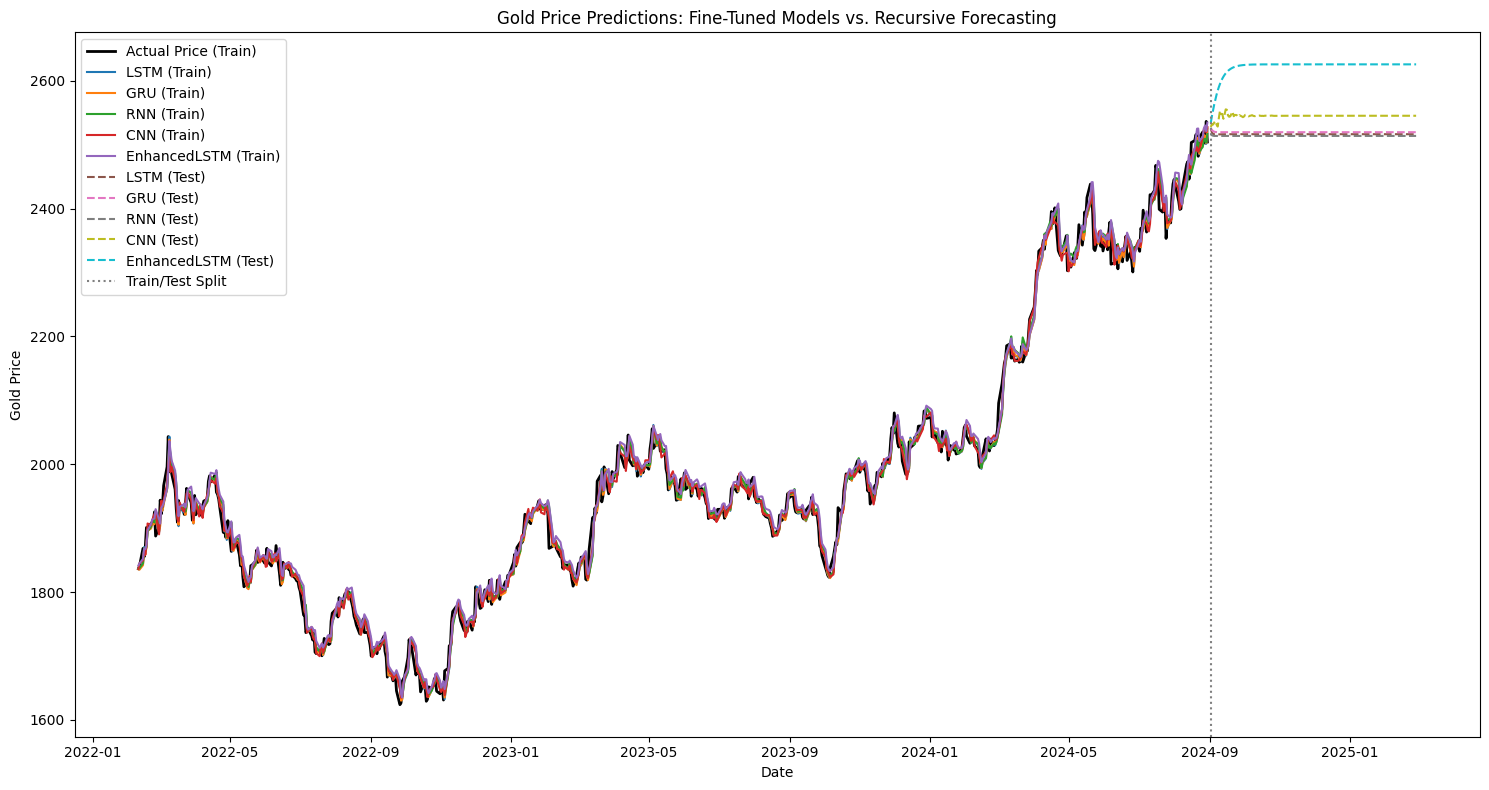

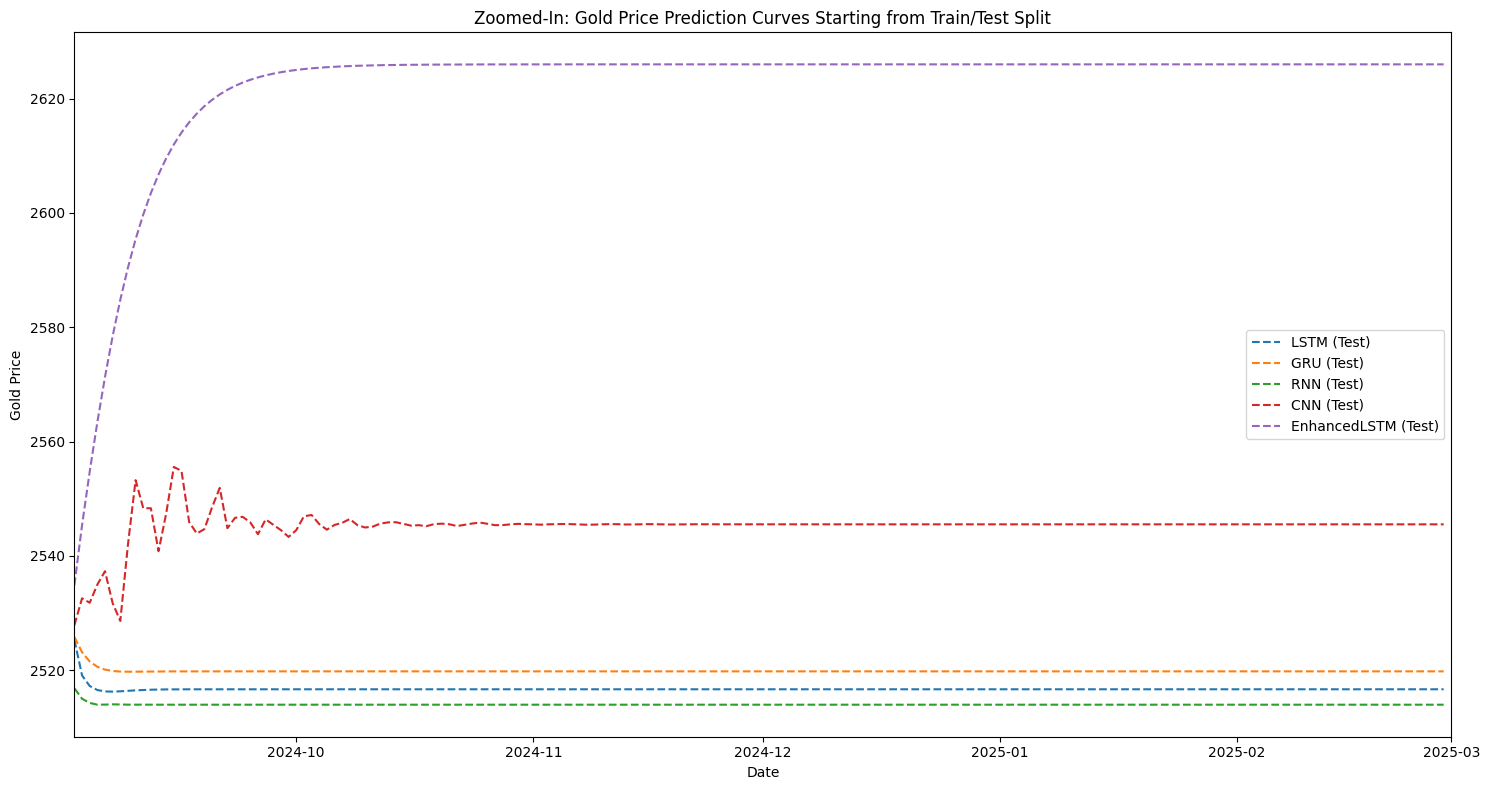

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# -------------------------------
# 1. Data Loading, Cleaning & Normalization
# -------------------------------
df = pd.read_csv('Gold Futures Historical Data_3Yr.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Remove commas from numeric columns and convert them to float64
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')

# We'll scale all features for better training dynamics.
features = ['Price', 'Open', 'High', 'Low']
data_all = df[features].values
scaler = StandardScaler()
data_all_scaled = scaler.fit_transform(data_all)

# -------------------------------
# 2. Splitting Data by Date
# -------------------------------
dates = df['Date']
# Define training period (up to 2025-01-02)
train_mask = dates < pd.to_datetime('2024-09-01')
# Use only training data for loss computation; test predictions are done recursively.
train_data_scaled = data_all_scaled[train_mask.values]
train_dates = dates[train_mask].reset_index(drop=True)

# -------------------------------
# 3. Create Sequences for Training
# -------------------------------
# Use a sliding window of fixed width to generate sequences.
window_width = 28

def create_sequences(data, dates, window_size):
    sequences = []
    targets = []
    target_dates = []
    for i in range(len(data) - window_size):
        seq = data[i:i+window_size]
        target = data[i+window_size][0]  # predicting the scaled Price
        sequences.append(seq)
        targets.append(target)
        target_dates.append(dates.iloc[i+window_size])
    return np.array(sequences), np.array(targets), np.array(target_dates)

X_train, y_train, train_target_dates = create_sequences(train_data_scaled, train_dates, window_width)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

# Create a DataLoader
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# -------------------------------
# 4. Define Fine-Tuned Models
# -------------------------------
class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM'):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        input_size = len(features)
        if model_type == 'LSTM':
            # Remove dropout to speed up convergence; weight decay will help regularize.
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.0,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=input_size,
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.0,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=input_size,
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                nonlinearity='relu',
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'CNN':
            self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            conv_output_length = window_width - 2 * (3 - 1)
            self.fc = nn.Linear(128 * conv_output_length, 1)
        elif model_type == 'EnhancedLSTM':
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=128,
                num_layers=3,
                batch_first=True,
                dropout=0.1,  # slightly reduced dropout
            )
            self.dropout = nn.Dropout(0.1)
            self.bn = nn.BatchNorm1d(128)
            self.fc = nn.Linear(128, 1)
        else:
            raise ValueError("Invalid model_type. Choose from 'LSTM', 'GRU', 'RNN', 'CNN', or 'EnhancedLSTM'.")

    def forward(self, x):
        if self.model_type == 'CNN':
            x = x.permute(0, 2, 1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type == 'EnhancedLSTM':
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        else:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        return out

# -------------------------------
# 5. Training Function with Weight Decay, Scheduler, Early Stopping, & Gradient Clipping
# -------------------------------
def train_model(model, train_loader, epochs=100, lr=5e-3, patience=10, clip_norm=1.0):
    """
    Train the model using MSELoss with weight decay (L2 regularization), a learning rate scheduler,
    early stopping, and gradient clipping.
    """
    criterion = nn.MSELoss()
    # Added weight_decay to help reduce overfitting.
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    best_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
            optimizer.step()
            epoch_loss += loss.item() * X_batch.size(0)
        epoch_loss /= len(train_loader.dataset)
        scheduler.step(epoch_loss)
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')
        
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"Early stopping after {epoch+1} epochs.")
            if best_model_state is not None:
                model.load_state_dict(best_model_state)
            break
    return model

# -------------------------------
# 6. Recursive Forecasting Function for the Test Window
# -------------------------------
def predict_future(model, initial_window, n_preds):
    """
    Recursively predict future (scaled) Price values.
    """
    preds = []
    current_window = initial_window.unsqueeze(0)
    model.eval()
    for _ in range(n_preds):
        with torch.no_grad():
            next_pred = model(current_window)
        next_value = next_pred.item()
        preds.append(next_value)
        # Update the current window with the new prediction in the 'Price' (first feature) position.
        last_row = current_window[0, -1, :].clone()
        last_row[0] = next_value
        new_window = torch.cat([current_window[0, 1:, :], last_row.unsqueeze(0)], dim=0)
        current_window = new_window.unsqueeze(0)
    return preds

# -------------------------------
# 7. Train Models and Generate Predictions
# -------------------------------
predictions_train = {}
predictions_test = {}
model_types = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']
forecast_horizon = 180  # Number of future time steps to predict

for m_type in model_types:
    print(f"\nTraining model: {m_type}")
    model = BaseModel(model_type=m_type)
    model = train_model(model, train_loader, epochs=150, lr=1e-3, patience=10, clip_norm=1.0)
    
    model.eval()
    with torch.no_grad():
        train_preds_scaled = model(X_train_tensor).squeeze().numpy()
    predictions_train[m_type] = train_preds_scaled
    
    last_train_window = X_train_tensor[-1]
    test_preds_scaled = predict_future(model, last_train_window, forecast_horizon)
    predictions_test[m_type] = test_preds_scaled

# -------------------------------
# 8. Inverse Transform Predictions and Plotting
# -------------------------------
def inverse_transform_price(scaled_values):
    # Create a dummy array with the same number of features; only the first column (Price) is set.
    dummy = np.zeros((len(scaled_values), len(features)))
    dummy[:, 0] = scaled_values
    inv = scaler.inverse_transform(dummy)
    return inv[:, 0]

y_train_inv = inverse_transform_price(y_train)
predictions_train_inv = {m: inverse_transform_price(pred) for m, pred in predictions_train.items()}
predictions_test_inv = {m: inverse_transform_price(pred) for m, pred in predictions_test.items()}

# Overall plot: Actual Training Prices and Test Predictions for all models
plt.figure(figsize=(15, 8))
plt.plot(train_target_dates, y_train_inv, label='Actual Price (Train)', color='black', linewidth=2)
for m_type in model_types:
    plt.plot(train_target_dates, predictions_train_inv[m_type],
             label=f'{m_type} (Train)', linestyle='-')
test_start_date = pd.to_datetime('2024-09-02')
test_dates = pd.date_range(start=test_start_date, periods=forecast_horizon, freq='D')
for m_type in model_types:
    plt.plot(test_dates, predictions_test_inv[m_type],
             label=f'{m_type} (Test)', linestyle='--')
plt.axvline(test_start_date, color='gray', linestyle=':', label='Train/Test Split')
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.title("Gold Price Predictions: Fine-Tuned Models vs. Recursive Forecasting")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# 9. Zoomed-In Plot of Test Predictions (Starting at the Train/Test Split)
# -------------------------------
plt.figure(figsize=(15, 8))
for m_type in model_types:
    plt.plot(test_dates, predictions_test_inv[m_type],
             label=f'{m_type} (Test)', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.title("Zoomed-In: Gold Price Prediction Curves Starting from Train/Test Split")
# Zoom in to, e.g., the first 30 days after the train/test split
plt.xlim(test_start_date, test_start_date + pd.Timedelta(days=180))
plt.legend()
plt.tight_layout()
plt.show()
